In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, precision_score, confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv("evgeni_set.csv")
df['age'] = df['age']/110 #нормализация

#Меня не устраивает что  в train_test_split может в тестовую выборку попасть 0 инфарктов или все 100
#поэтому разделю вручную и соеденю после деления обратно
df_heartattack_x = df[df['minf']==1].iloc[:, 1:]
df_heartattack_y = df[df['minf']==1].iloc[:, 0]
df_no_heartattack_x = df[df['minf']==0].iloc[:, 1:]
df_no_heartattack_y = df[df['minf']==0].iloc[:, 0]

df_heartattack_x_train, df_heartattack_x_test, df_heartattack_y_train, df_heartattack_y_test = train_test_split(df_heartattack_x, df_heartattack_y, test_size=0.2)
df_no_heartattack_x_train, df_no_heartattack_x_test, df_no_heartattack_y_train, df_no_heartattack_y_test = train_test_split(df_no_heartattack_x, df_no_heartattack_y, test_size=0.2)

x_train = pd.concat((df_heartattack_x_train, df_no_heartattack_x_train), axis=0)
y_train = pd.concat((df_heartattack_y_train, df_no_heartattack_y_train), axis=0)
x_test = pd.concat((df_heartattack_x_test, df_no_heartattack_x_test), axis=0)
y_test = pd.concat((df_heartattack_y_test, df_no_heartattack_y_test), axis=0)

In [3]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=2, algorithm='ball_tree')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
matrix = confusion_matrix(y_test, y_pred)
print(matrix)
print("recall: "+str(recall_score(y_test, y_pred)))
print("precision: "+str(precision_score(y_test, y_pred)))
print("accuracy_score: "+str(accuracy_score(y_test, y_pred)))
print("Доля обектов отнесеных к классу 1 от тестовой выборки: "+str(round((sum(matrix[:, 1])/x_test.shape[0])*100))+'%')

[[757  32]
 [  0  21]]
recall: 1.0
precision: 0.39622641509433965
accuracy_score: 0.9604938271604938
Доля обектов отнесеных к классу 1 от тестовой выборки: 7%


e:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [4]:
model.predict_proba(x_test)[(model.predict_proba(x_test)!=0)&(model.predict_proba(x_test)!=1)]

array([], dtype=float64)

In [5]:
y_train_pred = model.predict(x_train)
confusion_matrix(y_train, y_train_pred)

e:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([[3023,  129],
       [   0,   84]], dtype=int64)

In [6]:
x_train_for_pipeline = x_train[y_train_pred==1]
y_train_for_pipeline = y_train[y_train_pred==1]
x_test_for_pipeline = x_test[y_pred==1]
y_test_for_pipeline = y_test[y_pred==1]

In [7]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(n_estimators=100, depth=6, learning_rate=1, loss_function='Logloss', verbose=False)
model.fit(x_train_for_pipeline, y_train_for_pipeline)
y_pred_from_pipeline = model.predict(x_test_for_pipeline)
confusion_matrix(y_test_for_pipeline, y_pred_from_pipeline)

array([[26,  6],
       [ 6, 15]], dtype=int64)

In [8]:
print(f'reccal: {recall_score(y_test_for_pipeline,  y_pred_from_pipeline)}')
print(f'precision: {precision_score(y_test_for_pipeline,  y_pred_from_pipeline)}')

reccal: 0.7142857142857143
precision: 0.7142857142857143


In [10]:
from tqdm import tqdm

prediction = model.predict_proba(x_test_for_pipeline)
threshold_results = {'threshold':[], 'test_recall_score':[], 'test_f1_score':[], 'test_precision_score':[]}
iters = prediction[:, 1].copy()
iters.sort()
iters = np.unique(iters)

for i in tqdm(iters):
    predict_mine = []
    for i2 in prediction:
        if i2[1]>i:
            predict_mine.append(1)
        else:
            predict_mine.append(0)
            
    results['threshold'].append(i)
    results['test_recall_score'].append(recall_score(y_test_for_pipeline, predict_mine))
    results['test_f1_score'].append(f1_score(y_test_for_pipeline, predict_mine))
    results['test_precision_score'].append(precision_score(y_test_for_pipeline, predict_mine))

  0%|          | 0/14 [00:00<?, ?it/s]


NameError: name 'threshold_results' is not defined

In [ ]:
df_threshold_results = pd.DataFrame(threshold_results)
df_threshold_results

,threshold,test_recall_score,test_f1_score,test_precision_score
0,0.000047,0.904762,0.542857,0.387755
1,0.000080,0.857143,0.545455,0.400000
2,0.000241,0.761905,0.516129,0.390244
3,0.000306,0.666667,0.538462,0.451613
4,0.000311,0.619048,0.619048,0.619048
5,0.001042,0.571429,0.685714,0.857143
6,0.545091,0.523810,0.687500,1.000000
7,0.911849,0.380952,0.551724,1.000000
8,0.972038,0.285714,0.444444,1.000000
9,0.976895,0.238095,0.384615,1.000000


Text(0, 0.5, 'метрика')

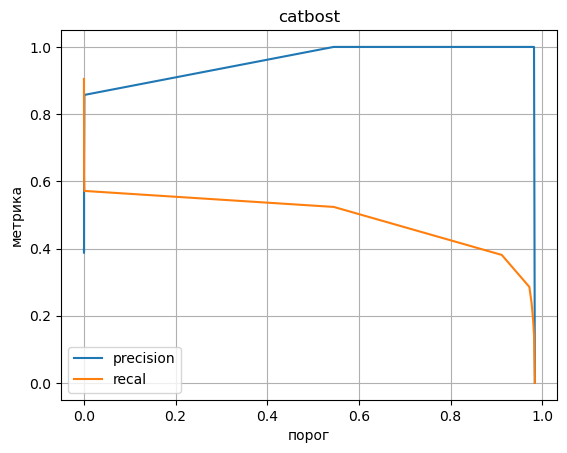

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df_threshold_results['threshold'], df_threshold_results['test_precision_score'], label='precision')
plt.plot(df_threshold_results['threshold'], df_threshold_results['test_recall_score'], label='recal')
plt.grid()
plt.legend()
plt.title('catbost')
plt.xlabel('порог')
plt.ylabel('метрика')